In [272]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
import json
import random

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]
    summary: str

async def create_graph():
    client = MultiServerMCPClient({
        "dummy_server": {
            "command": "uv",
            "args": ["run", "mcpserver.py"],
            "transport": "stdio"
        }
    })
    llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature=0, google_api_key = GOOGLE_API_KEY)
    tools = await client.get_tools()

    llm_with_tools = llm.bind_tools(tools)
    
    sys_prompt = await client.get_prompt(server_name="dummy_server", prompt_name="system_prompt")
    query_validation_prompt = await client.get_prompt(server_name="dummy_server", prompt_name="query_validation_prompt")

    async def get_tool_descriptions(tools):
        descriptions = []
    
        for tool in tools:
            tool_name = tool.name
            description = tool.description.strip().split("\n")[0]  # First line only
            args = tool.args_schema.get('properties', {})
            required_args = tool.args_schema.get('required', [])
    
            arg_list = []
            for arg in required_args:
                arg_type = args.get(arg, {}).get("type", "string")
                arg_list.append(f"{arg}: {arg_type}")
    
            arg_string = ", ".join(arg_list)
            full_description = f"{tool_name}({arg_string}) → {description}"
            descriptions.append(full_description)
    
        return "\n".join(f"{i+1}.{d}" for i, d in enumerate(descriptions))
    
    # we can add a conditional loop here after human query, to give human options to make prompt less ambiguous
    async def intent_and_slot_validator(state: MessagesState):
        user_query = state['messages'][-1]
        tool_descriptions = get_tool_descriptions(tools)
        validation_sys_message = SystemMessage(
            content=query_validation_prompt[0].content.format(tool_descriptions=tool_descriptions)
        )
        result = await llm_with_tools.ainvoke([validation_sys_message, user_query])
        return {'messages': [result]}

    async def agent_call(state: MessagesState):
        query = state['messages'][-1]
        if isinstance(query, ToolMessage):
            print(query)
            result = await llm_with_tools.ainvoke(state['messages'])
            return {'messages': [result]}
        try:
            query = query.content.strip('```json\n').strip('```')
            query = json.loads(query)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
        print()
        if query.get("unrelated", 'true'):
            return {
                "messages": [
                    AIMessage(content="Sorry, the query seems unfamiliar. I am a construction assistant and I can only help with construction related tasks.")
                ]
            }
        intents = query.get("intents", [])
        ambiguous_intents = [intent for intent in intents if intent["is_ambiguous"]]

        if ambiguous_intents:
            clarification_prompt = SystemMessage(content="""
            You're a helpful assistant. A user query was mapped to one or more tool calls, but some tools couldn't be used due to missing arguments.
            
            Your job is to:
            1. Read the JSON list of ambiguous tool intents.
            2. For each, clearly explain what is missing.
            3. Then ask the user nicely to provide that missing information.
            Respond as a friendly assistant — not in JSON — just plain language.
            """)
    
            human_message = HumanMessage(content=json.dumps(ambiguous_intents, indent=2))
            clarification_response = await llm_with_tools.ainvoke([clarification_prompt, human_message])
    
            return {
                "messages": [clarification_response]
            }
        tool_calls = [
            ToolCall(
                id=f"call_{int(random.random() * 1e18)}",  # large 18-digit integer
                name=intent["tool"],
                args=intent["arguments"]
            )
            for intent in intents
        ]

        tool_messages = AIMessage(
            content="",
            tool_calls=tool_calls
        )

    
        return {"messages": tool_messages}


    builder = StateGraph(MessagesState)

    builder.add_node('Query_Validation', intent_and_slot_validator)
    builder.add_node('Agent', agent_call)
    builder.add_node('tools', ToolNode(tools))
    # LOGIC
    builder.add_edge(START, 'Query_Validation')
    builder.add_edge('Query_Validation', 'Agent')
    builder.add_conditional_edges('Agent', tools_condition)
    builder.add_edge('tools', 'Agent')

    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)

    return graph, tools, sys_prompt, query_validation_prompt

I0000 00:00:1749793039.855638   55633 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1749793040.352883   55633 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
I0000 00:00:1749793040.670564   55633 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers


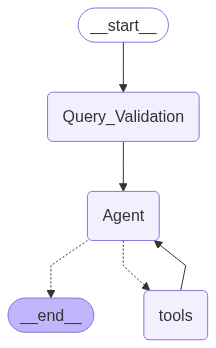

In [273]:
graph, tools, sys_prompt, query_validation_prompt = await create_graph()

graph

In [276]:
thread_config = {'configurable': {'thread_id': 2}}
await graph.ainvoke({'messages': ['Find the area of region A and scale of drawing']}, thread_config)

/Users/utkarshsharma/Desktop/Current_Projects/ConstructionAgent/.venv/lib/python3.11/site-packages/langgraph/utils/runnable.py:440: RuntimeWarning: coroutine 'create_graph.<locals>.get_tool_descriptions' was never awaited
  ret = await self.afunc(*args, **kwargs)


{'messages': [HumanMessage(content='Find the area of region A and scale of drawing', additional_kwargs={}, response_metadata={}, id='45811731-9369-4759-832a-09d8645e0cae'),
  AIMessage(content='```json\n{\n  "unrelated": false,\n  "intents": [\n    {\n      "tool": "measure_area",\n      "is_ambiguous": false,\n      "ambiguous_reason": null,\n      "arguments": {\n        "region": "A"\n      },\n      "missing_arguments": []\n    },\n    {\n      "tool": "get_scale",\n      "is_ambiguous": true,\n      "ambiguous_reason": "The drawing argument is missing.",\n      "arguments": {\n        "drawing": null\n      },\n      "missing_arguments": [\n        "drawing"\n      ]\n    }\n  ]\n}\n```', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--96123086-4647-4a4d-ae9f-84b6d5f9072c-0', usage_metadata={'input_tokens': 469, 'output_tokens': 155, 'to

In [228]:
graph.get_state(thread_config)

StateSnapshot(values={'messages': [HumanMessage(content='Find the area of region A', additional_kwargs={}, response_metadata={}, id='e2a004cb-f390-4657-bf3b-9279d551d61b'), AIMessage(content='```json\n{\n  "unrelated": false,\n  "intents": [\n    {\n      "tool": "measure_area",\n      "is_ambiguous": false,\n      "ambiguous_reason": null,\n      "arguments": {\n        "region": "region A"\n      },\n      "missing_arguments": []\n    }\n  ]\n}\n```', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--481fbcc4-e9ff-49f1-9878-6b417b772495-0', usage_metadata={'input_tokens': 499, 'output_tokens': 86, 'total_tokens': 585, 'input_token_details': {'cache_read': 0}}), AIMessage(content='', additional_kwargs={'tool_calls': [{'name': 'measure_area', 'arguments': {'region': 'region A'}}]}, response_metadata={}, id='786fdefa-9b0a-4e82-83d1-20d9d1c753a6'

In [176]:
s = graph.get_state(thread_config).values['messages'][1].content
s
json_string_clean = s.strip('```json\n').strip('```')
json_string_clean

'{\n  "unrelated": true,\n  "intents": []\n}'

In [177]:
json.loads(json_string_clean)

{'unrelated': True, 'intents': []}

In [183]:
s

'```json\n{\n  "unrelated": true,\n  "intents": []\n}\n```'